# Setup

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import cluster

In [2]:
INPUT_DIR = "../../data/input/"
OUTPUT_DIR = "../../data/output/"

# Load data

In [3]:
df = pd.read_csv(OUTPUT_DIR + "dataset.csv")
df.head()

,AvgCyclomatic,AvgEssential,AvgLine,CountDeclClass,CountDeclClassMethodRatio,CountDeclClassVariableRatio,CountDeclFunction,CountDeclInstanceMethodRatio,CountDeclMethod,CountDeclMethodDefaultRatio,...,AvgCountClassBase,AvgCountClassCoupled,AvgCountClassDerived,MaxInheritanceTree,AvgPercentLackOfCohesion,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting,Bug
0,1.0,1.0,9.0,1.0,0.0,9.0,17.0,1.0,17.0,0.176471,...,1.0,18.0,1.0,1.0,70.0,6.176471,3.941176,2.058824,2.0,0
1,2.0,1.0,8.0,2.0,0.0,0.0,21.0,1.0,21.0,0.000000,...,1.5,8.5,0.0,1.0,33.5,6.142857,3.142857,2.666667,3.0,0
2,2.0,1.0,14.0,1.0,0.0,2.0,21.0,1.0,21.0,0.000000,...,3.0,53.0,0.0,2.0,90.0,4.476190,4.142857,5.571429,4.0,0
3,2.0,1.0,29.0,1.0,0.0,17.0,8.0,1.0,8.0,0.125000,...,1.0,26.0,0.0,1.0,0.0,8.750000,5.750000,2.750000,2.0,0
4,2.0,1.0,17.0,1.0,0.0,0.0,6.0,1.0,6.0,0.000000,...,1.0,17.0,0.0,4.0,66.0,5.833333,8.500000,4.333333,2.0,0


# Correlation analysis

<AxesSubplot: >

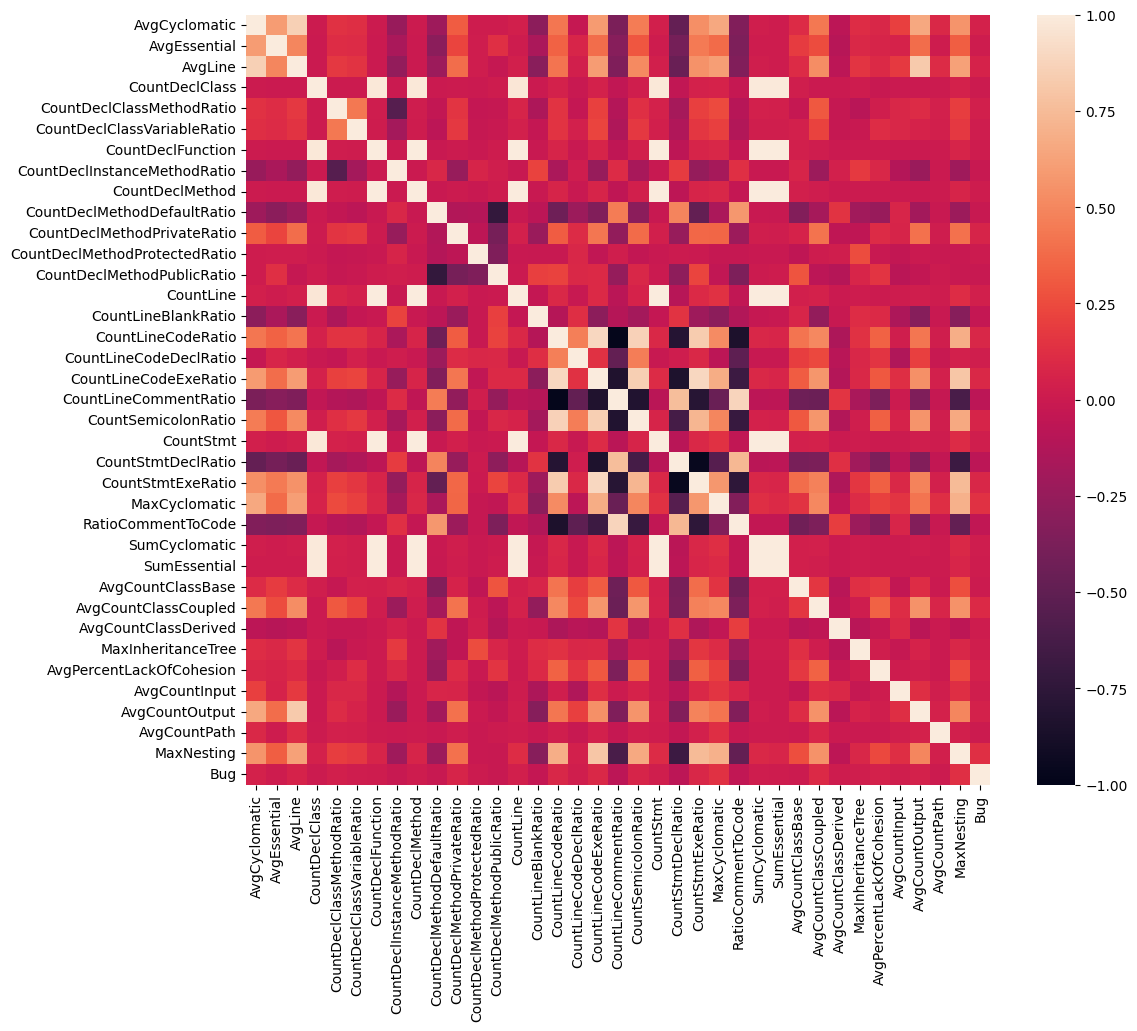

In [4]:
plt.figure(figsize=(12, 10))
r = df.corr()
sns.heatmap(r, vmin=-1, vmax=1)

## Variables clustering

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

dissimilarity = 1 - abs(r)
Z = linkage(squareform(dissimilarity), method="complete")

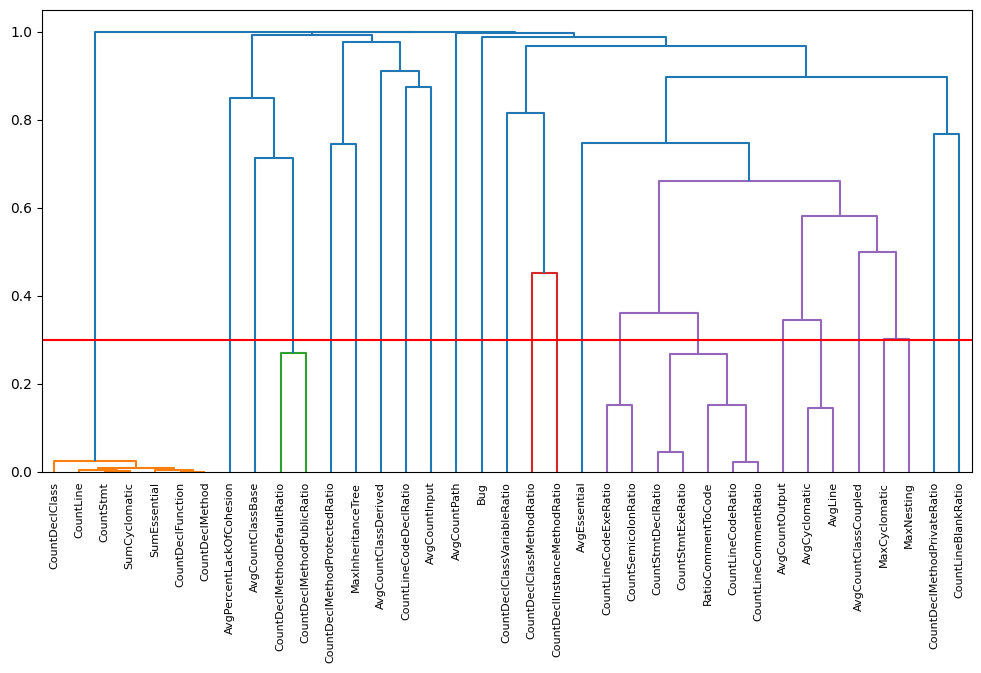

In [6]:

plt.figure(figsize=(12, 6))
dendrogram(Z, labels=df.columns, orientation="top", leaf_rotation=90)
plt.axhline(y = .3, c="red")

Let us retain one independant variable for every cluster with a dissimilarity below 0.3.

In [7]:
df = df.drop(['CountDeclClass', 'CountStmt', 'SumCyclomatic', 'SumEssential', 'CountDeclFunction', 'CountDeclMethod', 
              'CountDeclMethodDefaultRatio', 'CountLineCodeExeRatio', 'CountSemicolonRatio', 'CountStmtDeclRatio',
              'CountStmtExeRatio', 'CountLineCodeRatio', 'CountLineCommentRatio', 'AvgLine'], axis=1)

The dissimilartity dendrogram of the remaining variable confirm that no two variables ahve a correlation above 0.70.

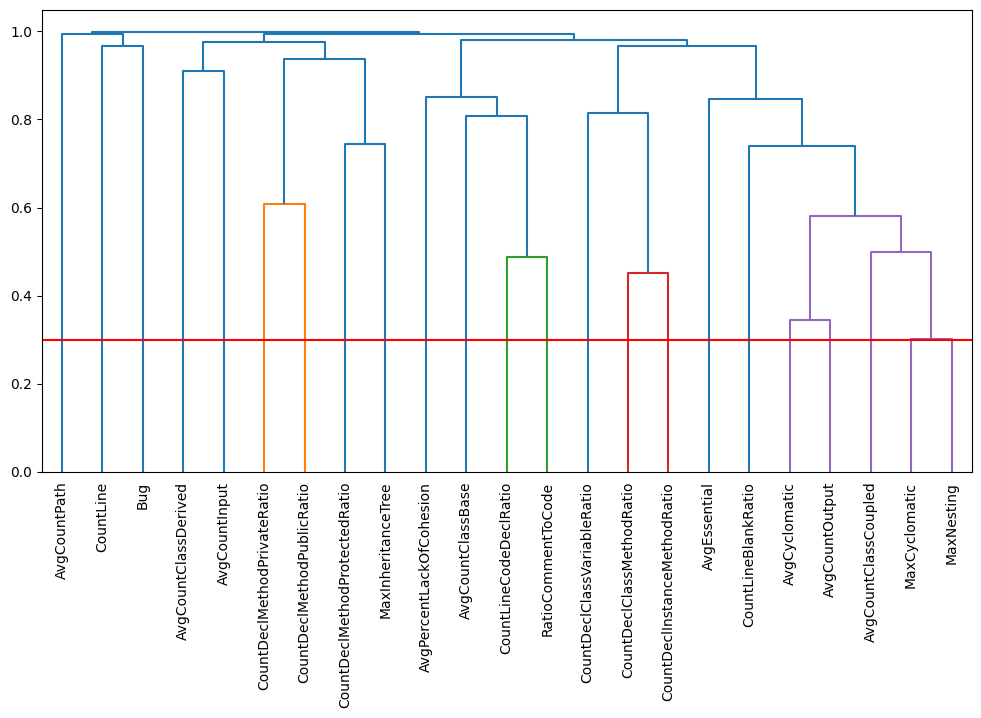

In [8]:
dissimilarity = 1 - abs(df.corr())
Z = linkage(squareform(dissimilarity), method="complete")

plt.figure(figsize=(12, 6))
dendrogram(Z, labels=df.columns, orientation="top", leaf_rotation=90)
plt.axhline(y = .3, c="red")

Lets shuffle this final dataset and save this new order.

In [9]:
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv(OUTPUT_DIR + "dataset_independent.csv", index=False)

## Train / test split

To validate our models, we choose to split the data into train and test sets.

In [11]:
df = pd.read_csv(OUTPUT_DIR + "dataset_independent.csv")
df

,AvgCyclomatic,AvgEssential,CountDeclClassMethodRatio,CountDeclClassVariableRatio,CountDeclInstanceMethodRatio,CountDeclMethodPrivateRatio,CountDeclMethodProtectedRatio,CountDeclMethodPublicRatio,CountLine,CountLineBlankRatio,...,AvgCountClassBase,AvgCountClassCoupled,AvgCountClassDerived,MaxInheritanceTree,AvgPercentLackOfCohesion,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting,Bug
0,3.0,1.0,0.5,2.000000,0.955224,0.029851,0.000000,0.955224,1023.0,0.109482,...,2.200000,13.200000,0.000000,2.0,15.600000,3.938462,3.953846,161.615385,4.0,0
1,2.0,2.0,0.0,0.125000,1.000000,0.600000,0.000000,0.400000,509.0,0.119843,...,2.000000,17.000000,0.000000,1.0,12.285714,4.173913,7.086957,4.565217,4.0,0
2,2.0,1.0,0.5,1.166667,0.930233,0.046512,0.000000,0.930233,500.0,0.148000,...,2.200000,10.600000,0.000000,2.0,14.000000,4.560976,3.146341,2.463415,3.0,0
3,1.0,1.0,0.0,0.000000,1.000000,0.000000,0.238095,0.714286,269.0,0.126394,...,1.500000,12.000000,1.500000,3.0,74.000000,2.428571,3.809524,2.095238,3.0,0
4,4.0,1.0,0.0,1.000000,1.000000,0.333333,0.000000,0.666667,250.0,0.116000,...,1.000000,20.500000,0.000000,2.0,0.000000,3.333333,15.000000,120.666667,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75245,1.0,1.0,0.0,0.833333,1.000000,0.041667,0.000000,0.916667,210.0,0.157143,...,1.333333,2.833333,0.666667,2.0,3.500000,2.583333,2.291667,1.791667,1.0,0
75246,4.0,1.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,52.0,0.115385,...,1.000000,7.000000,0.000000,2.0,0.000000,1.000000,13.000000,5.000000,1.0,0
75247,11.0,5.0,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,112.0,0.125000,...,2.000000,19.000000,0.000000,2.0,0.000000,4.000000,15.000000,27.000000,4.0,0
75248,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,36.0,0.111111,...,0.000000,4.000000,2.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0


Let's check the bugs count

In [13]:
df["Bug"].value_counts()

0    74276
1      974
Name: Bug, dtype: int64

<AxesSubplot: xlabel='Bug', ylabel='count'>

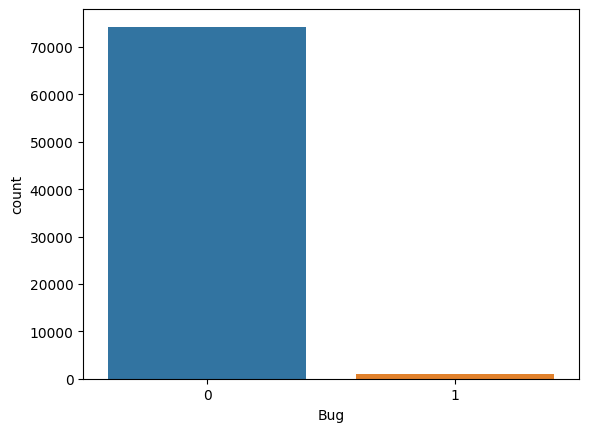

In [12]:
sns.countplot(df, x="Bug")

In [15]:
train, test = train_test_split(df, test_size=.2, random_state=1)

We check if we have a good repartition of bugs in train and test datasets

<AxesSubplot: xlabel='Bug', ylabel='count'>

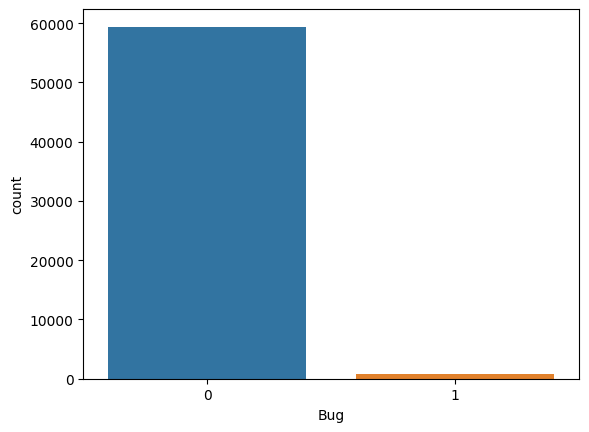

In [16]:
sns.countplot(train, x="Bug")

In [26]:
no, yes = train["Bug"].value_counts()
print(f"{(yes*100)/no} % in train set")

1.343389111477728 % in train set


<AxesSubplot: xlabel='Bug', ylabel='count'>

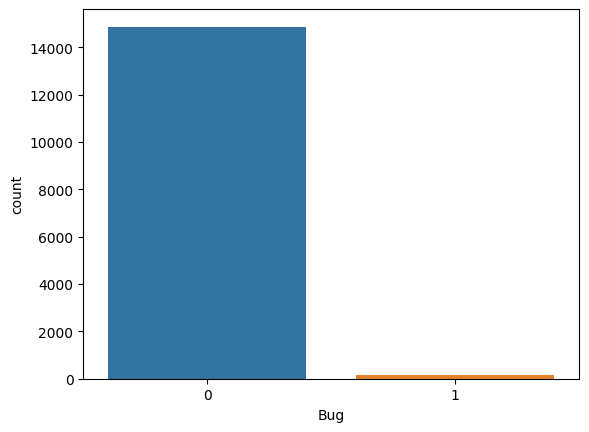

In [17]:
sns.countplot(test, x="Bug")

In [27]:
no, yes = test["Bug"].value_counts()
print(f"{(yes*100)/no} % in test set")

1.1832728250638698 % in test set


Let's save our new training and testing sets.

In [28]:
train.to_csv(OUTPUT_DIR + "train.csv", index=False)
test.to_csv(OUTPUT_DIR + "test.csv", index=False)